In [1]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from deepxde.callbacks import ModelCheckpoint

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Set random seed
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)
dde.backend.tf.random.set_random_seed(seed)

# Set hyperparameters
n_output = 3 # postition (x), theta, force on cart (u_norm)

num_domain = 1000

n_adam = 5000

lr = 2e-2 # for Adam
loss_weights = [1., 1., 1., 1., 1., 1, 1., 10.]

# Set physical parameters
tmin, tmax = 0.0, 10.0
# xmin, xmax = -5.0, 5.0
target = 0. # cos(theta) should be close to 180 degrees

# Define constants
M = 2 # Mass of the cart
m = 1 # Mass of the pendulum
b = 0.1 # Friction coefficient
I = 0.33 # Moment of inertia
g = 9.8 # Gravity
l = 1 # Length of the pendulum
force_max = 25  # Maximum force

In [3]:
class Custom_BC(dde.icbc.BC):
    def __init__(self, geom, func, on_boundary, component=0):
        super().__init__(geom, on_boundary, component)
        self.func = dde.icbc.boundary_conditions.npfunc_range_autocache(dde.utils.return_tensor(func))
        
    def error(self, X, inputs, outputs, beg, end, aux_var=None):
        # beg and end specify the current batch range
        values = self.func(X, beg, end, aux_var)
        theta = outputs[:, 0:1]
        # goal = tf.cos(theta)
        goal = theta * 180 / np.pi
        print('Goal:', goal)
        return (goal[beg:end, self.component:self.component + 1] - values) ** 2

In [4]:
def ode(t, u):
    x, theta, force_norm = u[:, 0:1], u[:, 1:2], tf.tanh(u[:, 2:3])
    force = force_max * force_norm
    x_dot = dde.grad.jacobian(x, t)
    theta_dot = dde.grad.jacobian(theta, t)
    x_ddot = dde.grad.jacobian(x_dot, t)
    theta_ddot = dde.grad.jacobian(theta_dot, t)

    denominator = I * (M + m) + M * m * l * l

    res1 = x_ddot - (((-(I + m * l * l) * b * x_dot) + (m * m * g * l * l * theta) + ((I + m * l * l) * force)) / denominator)
    res2 = theta_ddot - (((-m * b * l * theta_dot) + (m * g * (M + m) * l * theta) +( m * l * force)) / denominator)

    return [res1, res2]

In [5]:
def initial(_, on_initial):
    return on_initial

def boundary_left(t, on_boundary):
    '''
        on_boundary is passed here by deepxde and it serves as an intial filter which tells if a point lies on the boundary or not

        np.isclose(t[0], tmin) checks if the point is on the left boundary or not and this is a second filter
    '''

    return on_boundary * np.isclose(t[0], tmin)

def boundary_right(t, on_boundary):
    '''
        on_boundary is passed here by deepxde and it serves as an intial filter which tells if a point lies on the boundary or not

        np.isclose(t[0], tmax) checks if the point is on the right boundary or not and this is a second filter
    '''

    return on_boundary * np.isclose(t[0], tmax)

In [6]:
geom = dde.geometry.TimeDomain(tmin, tmax)

# INITIAL CONDITIONS
position_initial = dde.icbc.IC(geom, lambda t: np.array([0.]), initial, component=0) # posittion = 0 at time = 0
theta_initial = dde.icbc.IC(geom, lambda t: np.array([0.]), initial, component=1) # theta = 0 at time = 0
force_initial = dde.icbc.IC(geom, lambda t: np.array([0.]), initial, component=2) # force = 0 at time = 0

# NEUMANN CONDITIONS
velocity_initial = dde.icbc.NeumannBC(geom, lambda t: np.array([0.]), boundary_left, component=0) # cart velocity = 0 at time = 0
angular_velocity_initial = dde.icbc.NeumannBC(geom, lambda t: np.array([0.]), boundary_left, component=1) # angular velocity 1 = 0 at time = 0

# CUSTOM BOUNDARY CONDITIONS - GOAL AND POSITION RANGE
goal = Custom_BC(geom, lambda t: np.array([target]), boundary_right) # custom ICBC

losses = [position_initial, theta_initial, force_initial, velocity_initial, angular_velocity_initial, goal]

data = dde.data.PDE(geom, ode, losses, num_domain=num_domain, num_boundary=20)
# dataset size here will be 1002 (1000 domain + 2 boundary)

In [7]:
net = dde.nn.FNN([1] + [128] * 3 + [n_output], "tanh", "Glorot normal")

In [8]:
resampler = dde.callbacks.PDEPointResampler(period=100)

In [9]:
model = dde.Model(data, net)
model.compile("adam", lr=lr, loss_weights=loss_weights)

Compiling model...
Building feed-forward neural network...
'build' took 0.032139 s



Goal: Tensor("truediv_2:0", shape=(None, 1), dtype=float32)
Goal: Tensor("truediv_5:0", shape=(None, 1), dtype=float32)


/Users/arjundosajh/miniconda3/envs/ml/lib/python3.11/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.344798 s



In [10]:
model_checkpoint = ModelCheckpoint(
    filepath='checkpoints/best_model.ckpt',  # Path to save the model file
    monitor='test loss',          # Monitor the validation loss
    save_better_only=True          # Only save when the monitored quantity (val_loss) has improved
)

In [11]:
print("Residual 1 | Residual 2 | Initial Position | Initial Theta | Initial Force | Initial Velocity | Initial Angular Velocity | Goal")
losshistory, train_state = model.train(display_every=10, iterations=n_adam, callbacks=[resampler, model_checkpoint])

Residual 1 | Residual 2 | Initial Position | Initial Theta | Initial Force | Initial Velocity | Initial Angular Velocity | Goal
Training model...



2024-02-05 02:38:31.388913: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


Step      Train loss                                                                          Test loss                                                                           Test metric
0         [2.06e+01, 8.20e+01, 0.00e+00, 0.00e+00, 0.00e+00, 1.84e-03, 7.53e-02, 7.90e+00]    [2.06e+01, 8.20e+01, 0.00e+00, 0.00e+00, 0.00e+00, 1.84e-03, 7.53e-02, 7.90e+00]    []  
INFO:tensorflow:checkpoints/best_model.ckpt-1.ckpt is not in all_model_checkpoint_paths. Manually adding it.
10        [2.99e-01, 1.05e+02, 5.05e-01, 1.58e+00, 2.70e-01, 3.09e-02, 6.31e-01, 4.94e+07]    [2.99e-01, 1.05e+02, 5.05e-01, 1.58e+00, 2.70e-01, 3.09e-02, 6.31e-01, 4.94e+07]    []  
20        [3.90e+01, 3.91e+01, 2.32e+00, 1.96e+00, 2.09e+01, 3.00e-02, 1.28e-01, 6.52e+08]    [3.90e+01, 3.91e+01, 2.32e+00, 1.96e+00, 2.09e+01, 3.00e-02, 1.28e-01, 6.52e+08]    []  
30        [4.59e+01, 2.20e+01, 1.66e+00, 1.59e+00, 2.22e+01, 4.79e-03, 8.67e-02, 3.04e+08]    [4.59e+01, 2.20e+01, 1.66e+00, 1.59e+00, 2.22e+01, 4.79e-0

## Getting the predictions for time = 0 to time = 10 at intervals of 0.01

In [12]:
model.restore(save_path='checkpoints/best_model.ckpt-4900.ckpt')

t = np.linspace(tmin, tmax, 101)
predictions = model.predict(np.array([t]).T)
predictions[:, 2] = np.tanh(predictions[:, 2]) * force_max

predictions.shape

INFO:tensorflow:Restoring parameters from checkpoints/best_model.ckpt-4900.ckpt


(101, 3)

In [13]:
np.save('single_inverted_cart_outputs.npy', predictions)
predictions

array([[ 0.00729251, -0.00807563, -0.31767628],
       [ 0.00987229, -0.00754616, -0.08269355],
       [ 0.01163517, -0.0073103 ,  0.0329641 ],
       [ 0.01265239, -0.00725381,  0.08111767],
       [ 0.0131622 , -0.00724036,  0.09191214],
       [ 0.01336651, -0.0071917 ,  0.0830576 ],
       [ 0.01340319, -0.00707939,  0.06490107],
       [ 0.01335867, -0.00690293,  0.04335298],
       [ 0.01328294, -0.00667568,  0.02164686],
       [ 0.01320349, -0.00641435,  0.0014327 ],
       [ 0.01313343, -0.00613397, -0.01657014],
       [ 0.01307864, -0.00584766, -0.03217126],
       [ 0.01303971, -0.00556523, -0.04545878],
       [ 0.01301583, -0.00529304, -0.05661542],
       [ 0.01300491, -0.00503565, -0.06592375],
       [ 0.01300462, -0.0047954 , -0.07363503],
       [ 0.01301235, -0.0045737 , -0.08000523],
       [ 0.01302642, -0.00437039, -0.08525354],
       [ 0.01304509, -0.00418523, -0.08957464],
       [ 0.01306678, -0.00401698, -0.0931315 ],
       [ 0.01309063, -0.00386497, -0.096

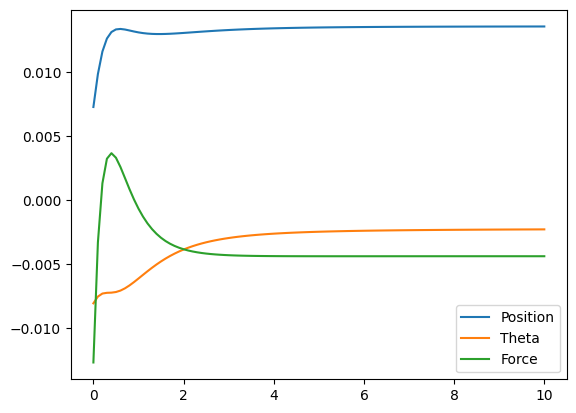

In [14]:
t = np.linspace(tmin, tmax, 101)
uu = model.predict(np.array([t]).T)
plt.plot(t, uu[:, 0])
plt.plot(t, np.tanh(uu[:, 1]))
plt.plot(t, np.tanh(uu[:, 2]))
plt.legend(["Position", "Theta", "Force"])
plt.show()